In [1]:
import salabim as sim
import math

In [2]:


# Constants
up = 1
down = -1
still = 0

move_time = 2
dooropen_time = 2
doorclose_time = 2

enter_time = 2
exit_time = 1

capacity = 8

topfloor = 12  # 0: Ground floor, 1-12: Employee floors

elevatorcount = 2 

id = "morning" #persons created in the morning

def run_simulation(seed: int, trace=True, sim_duration=10*3600, warmup=30) -> list:
    env = sim.Environment(random_seed=seed)
    env.animation_parameters(animate=True, title="Elevator Simulation")
    
    class PersonGenerator(sim.Component):
        def setup(self, from_, to, id, *args, **kwargs):
            self.from_ = from_
            self.to = to
            self.id = id

        def process(self):
            while True:
                from_ = sim.random.randint(0, topfloor)
                while True:
                    to = sim.random.randint(0, topfloor)
                    if from_ != to:
                        break

                    iat = 3600 / load
                    r = sim.random.uniform(0.5, 1.5)
                    yield self.hold(r * iat)


    class Person(sim.Component):
        def setup(self, from_, to, *args, **kwargs):
            self.fromfloor = floors[from_]
            self.tofloor = floors[to]
            self.direction = getdirection(self.fromfloor, self.tofloor)
            self.animate = sim.AnimateCircle(x=10,y=from_ * 30 + 15, radius=10, fillcolor="green", text=f"{self.name()}")
            

        def process(self):
            self.enter(self.fromfloor.Persons)
            self.animate.x = 20
            pos = 20
            # Walking effect
            while pos < 150:
                self.animate.x = pos  # Adjust the value for speed
                pos += 5
                self.hold(0.5)  # Adjust the time for speed

            if not (self.fromfloor, self.direction) in requests:
                requests[self.fromfloor, self.direction] = self.env.now()
            
            self.enter(waitingline) 

            # Slight randomization for a natural queue formation
            self.animate.x = 150 + sim.random.uniform(-15, 15)
            self.animate.y = self.fromfloor.n * 30 + 15

            # Using the function to choose the elevator
            chosen_elevator = choose_elevator(self.fromfloor, self.direction)
        
            # Add the request to the chosen elevator's request list
            chosen_elevator.requests[(self.fromfloor, self.direction)] = self.env.now()            
            if chosen_elevator.status() == 'passive':
                chosen_elevator.activate()
            self.passivate()

    class Elevator(sim.Component):
        def setup(self, capacity,requests):
            self.capacity = capacity
            self.direction = still
            self.requests = requests 
            self.floor = floors[0]
            self.Persons = sim.Queue(name="Persons in Elevator")
            self.time_spent_moving = 0  # Initialize the time_spent_moving attribute
            self.last_movement_time = self.env.now()  # Initialize the last_movement_time attribute
            self.animate = sim.AnimateRectangle((250, 0, 450, 30), fillcolor="orange", text=f"Elevator {self.name()}")


        def process(self):
            while True:
                if len(self.requests) == 0:
                    self.passivate()
                else:
                    self.activate()
                    for direction, target_floor in [(up, topfloor), (down, 0)]:
                        for floor in range(self.floor.n, target_floor + direction, direction):
                            current_floor = floors[floor]

                            # Unload passengers if needed
                            if any(Person.tofloor == current_floor for Person in self.Persons):
                                self.hold(exit_time)
                                for Person in list(self.Persons):
                                    if Person.tofloor == current_floor:
                                        Person.leave(self.Persons)
                                        Person.activate()
                                        Person.animate.x = 500  # some arbitrary position to represent the departure

                            # Load passengers if needed
                            if (current_floor, direction) in self.requests:
                                del self.requests[current_floor, direction]
                                self.hold(dooropen_time)

                                for Person in list(current_floor.Persons):
                                    if len(self.Persons) < capacity:
                                        Person.leave(current_floor.Persons)
                                        self.person = waitingline.pop()
                                        Person.enter(self.Persons)
                                        Person.animate.x = 350 + sim.random.uniform(-25, 25) # inside the elevator
                                        Person.animate.y = self.floor.n * 30 + 15


                                self.hold(enter_time)
                                self.hold(doorclose_time)

                            #Logic for choosing the elevator


                            # Move to the next floor
                            if floor != target_floor:
                                self.hold(move_time)
                            self.floor = floors[floor]
                            for Person in list(self.Persons):
                                Person.animate.y=self.floor.n * 30 + 25
                            self.animate.y = self.floor.n * 30 + 15

                             # Update time spent moving at each tick
                            self.time_spent_moving += self.env.now() - self.last_movement_time
                            self.last_movement_time = self.env.now()

                             #Generate staircase sequence if waiting line is too big
                            if waitingline.length() > 16 and target_floor - floor < 3:
                                Person.leave(current_floor.Persons)
                                self.person = waitingline.pop()

                    # Account for dooropen_time and exit_time
                    self.hold(dooropen_time + exit_time)
                    self.time_spent_moving -= dooropen_time + exit_time




        def count_to_floor(self, tofloor):
            n = 0
            for Person in self.Persons:
                if Person.tofloor == tofloor:
                    n += 1
            return n


    class Floor:
        def __init__(self, n):
            self.n = n
            self.Persons = sim.Queue(name=f"Persons {n}")
            self.animate = sim.AnimateRectangle((0, n*30, 200, (n+1)*30), fillcolor="lightblue", text=f"Floor {n}")

    def getdirection(fromfloor, tofloor):
        return up if fromfloor.n < tofloor.n else down
    def choose_elevator(requesting_floor, direction):
        elevator1_distance = abs(Elevator1.floor.n - requesting_floor.n)
        elevator2_distance = abs(Elevator2.floor.n - requesting_floor.n)

        # Case 1: One elevator is idle
        if Elevator1.direction == still and Elevator2.direction != still:
            return Elevator1
        elif Elevator2.direction == still and Elevator1.direction != still:
            return Elevator2

        # Case 2: Both are idle
        elif Elevator1.direction == still and Elevator2.direction == still:
            return Elevator1 if elevator1_distance < elevator2_distance else Elevator2

        # Case 3: Both are moving
        else:
            # Elevator1 is moving towards the request
            if (Elevator1.direction == direction and 
                ((direction == up and Elevator1.floor.n < requesting_floor.n) or 
                 (direction == down and Elevator1.floor.n > requesting_floor.n))):
                return Elevator1
        
            # Elevator2 is moving towards the request
            elif (Elevator2.direction == direction and 
                  ((direction == up and Elevator2.floor.n < requesting_floor.n) or 
                   (direction == down and Elevator2.floor.n > requesting_floor.n))):
                return Elevator2

            # Both are moving away from the request
            else:
                return Elevator1 if elevator1_distance < elevator2_distance else Elevator2


    waitingline = sim.Queue("waitingline")
    floors = {ifloor: Floor(ifloor) for ifloor in range(topfloor + 1)}
    #elevator = Elevator(capacity=capacity, at=0)
    

    # Initialize the floor and elevator instances
    requests = {}
    floors = {ifloor: Floor(ifloor) for ifloor in range(topfloor + 1)}
    Elevator1 = Elevator(requests=requests, capacity=capacity, at=0)
    Elevator2 = Elevator(requests=requests, capacity=capacity, at=0)
    
    # Create monitoring objects for time spent moving for each elevator
    elevator1_time_monitor = sim.Monitor(name="Elevator 1 Time Moving")
    elevator2_time_monitor = sim.Monitor(name="Elevator 2 Time Moving")
    
    # Generate 396 employees going from the ground floor to random employee floors
    for i in range(396):
        to_floor = sim.random.randint(0, topfloor)
        from_floor = sim.random.randint(0, topfloor)
        Person(from_=from_floor, to=to_floor, at=i*9)

    # Generate 80 random moves for the 8 working hours (10 moves per hour)
    for i in range(80):
        from_floor, to_floor = sim.random.randint(0, topfloor), sim.random.randint(0, topfloor)
        while from_floor == to_floor:
            from_floor, to_floor = sim.random.randint(0, topfloor), sim.random.randint(0, topfloor)
        Person(from_=from_floor, to=to_floor, at=3600 + i*450)
        
    #Generate 180 random customers 8 at working hours
    for i in range(180):
        to_floor = sim.random.randint(0, topfloor)
        from_floor = sim.random.randint(0, topfloor)
        Person(from_=from_floor, to=to_floor, at=3600+ i*160)
    
    env.run(duration=36000)  # Run for 10 hours (3600*10)
    
    # Enable monitoring after warmup
    waitingline.monitor(True)
    for floor in floors.values():
        floor.Persons.monitor(True)
    elevator1_time_monitor.monitor(True)
    elevator2_time_monitor.monitor(True)

    env.run(duration=sim_duration)
    
     # Collect statistics for time spent moving for each elevator
    elevator1_time_monitor.tally(Elevator1.time_spent_moving)
    elevator2_time_monitor.tally(Elevator2.time_spent_moving)

    monitored = [waitingline] + [floor.Persons for floor in floors.values()]
    monitored += [elevator1_time_monitor, elevator2_time_monitor]
    return {queue.name(): queue for queue in monitored}

if __name__ == "__main__":
    res = run_simulation(seed=42, trace=True, sim_duration=36000, warmup=30)
    for name, queue in res.items():
        print("--------------------------")
        queue.print_statistics()



SimulationStopped: 

In [5]:


# Constants
up = 1
down = -1
still = 0

move_time = 2
dooropen_time = 2
doorclose_time = 2

enter_time = 2
exit_time = 1

capacity = 8

topfloor = 12  # 0: Ground floor, 1-12: Employee floors

elevatorcount = 2 

id = "morning" #persons created in the morning

def run_simulation(seed: int, trace=True, sim_duration=10*3600, warmup=30) -> list:
    env = sim.Environment(random_seed=seed)
    #env.animation_parameters(animate=True, title="Elevator Simulation")
    
    class PersonGenerator(sim.Component):
        def setup(self, from_, to, id, *args, **kwargs):
            self.from_ = from_
            self.to = to
            self.id = id

        def process(self):
            while True:
                from_ = sim.random.randint(0, topfloor)
                while True:
                    to = sim.random.randint(0, topfloor)
                    if from_ != to:
                        break

                    iat = 3600 / load
                    r = sim.random.uniform(0.5, 1.5)
                    yield self.hold(r * iat)


    class Person(sim.Component):
        def setup(self, from_, to, *args, **kwargs):
            self.fromfloor = floors[from_]
            self.tofloor = floors[to]
            self.direction = getdirection(self.fromfloor, self.tofloor)
            #self.animate = sim.AnimateCircle(x=10,y=from_ * 30 + 15, radius=10, fillcolor="green", text=f"{self.name()}")
            

        def process(self):
            self.enter(self.fromfloor.Persons)
            #self.animate.x = 30
            pos = 30
            # Walking effect
            #while pos < 150:
                #self.animate.x = pos  # Adjust the value for speed
                #pos += 5
                #self.hold(0.5)  # Adjust the time for speed

            if not (self.fromfloor, self.direction) in requests:
                requests[self.fromfloor, self.direction] = self.env.now()
            
            self.enter(waitingline) 

            # Slight randomization for a natural queue formation
            #self.animate.x = 180 + sim.random.uniform(-15, 15)
            #self.animate.y = self.fromfloor.n * 30 + 15

            # Using the function to choose the elevator
            chosen_elevator = choose_elevator(self.fromfloor, self.direction)
        
            # Add the request to the chosen elevator's request list
            chosen_elevator.requests[(self.fromfloor, self.direction)] = self.env.now()            
            if chosen_elevator.status() == 'passive':
                chosen_elevator.activate()
            self.passivate()

    class Elevator(sim.Component):
        def setup(self, capacity,requests):
            self.capacity = capacity
            self.direction = still
            self.requests = requests 
            self.floor = floors[0]
            self.Persons = sim.Queue(name="Persons in Elevator")
            self.time_spent_moving = 0  # Initialize the time_spent_moving attribute
            self.last_movement_time = self.env.now()  # Initialize the last_movement_time attribute
            #self.animate = sim.AnimateRectangle((250, 0, 450, 30), fillcolor="orange", text=f"Elevator {self.name()}")


        def process(self):
            while True:
                if len(self.requests) == 0:
                    self.passivate()
                else:
                    self.activate()
                    for direction, target_floor in [(up, topfloor), (down, 0)]:
                        for floor in range(self.floor.n, target_floor + direction, direction):
                            current_floor = floors[floor]

                            # Unload passengers if needed
                            if any(Person.tofloor == current_floor for Person in self.Persons):
                                self.hold(exit_time)
                                for Person in list(self.Persons):
                                    if Person.tofloor == current_floor:
                                        Person.leave(self.Persons)
                                        Person.activate()
                                        #Person.animate.x = 500  # some arbitrary position to represent the departure

                            # Load passengers if needed
                            if (current_floor, direction) in self.requests:
                                del self.requests[current_floor, direction]
                                self.hold(dooropen_time)

                                for Person in list(current_floor.Persons):
                                    if len(self.Persons) < capacity:
                                        Person.leave(current_floor.Persons)
                                        self.person = waitingline.pop()
                                        Person.enter(self.Persons)
                                        #Person.animate.x = 350 + sim.random.uniform(-25, 25) # inside the elevator
                                        #Person.animate.y = self.floor.n * 30 + 15


                                self.hold(enter_time)
                                self.hold(doorclose_time)

                            #Logic for choosing the elevator


                            # Move to the next floor
                            if floor != target_floor:
                                self.hold(move_time)
                            self.floor = floors[floor]
                            #for Person in list(self.Persons):
                                #Person.animate.y=self.floor.n * 30 + 25
                            #self.animate.y = self.floor.n * 30 + 15

                             # Update time spent moving at each tick
                            self.time_spent_moving += self.env.now() - self.last_movement_time
                            self.last_movement_time = self.env.now()

                             #Generate staircase sequence if waiting line is too big
                            if waitingline.length() > 16 and target_floor - floor < 3:
                                Person.leave(current_floor.Persons)
                                self.person = waitingline.pop()

                    # Account for dooropen_time and exit_time
                    self.hold(dooropen_time + exit_time)
                    self.time_spent_moving -= dooropen_time + exit_time




        def count_to_floor(self, tofloor):
            n = 0
            for Person in self.Persons:
                if Person.tofloor == tofloor:
                    n += 1
            return n


    class Floor:
        def __init__(self, n):
            self.n = n
            self.Persons = sim.Queue(name=f"Persons {n}")
            #self.animate = sim.AnimateRectangle((0, n*30, 200, (n+1)*30), fillcolor="lightblue", text=f"Floor {n}")

    def getdirection(fromfloor, tofloor):
        return up if fromfloor.n < tofloor.n else down
    def choose_elevator(requesting_floor, direction):
        elevator1_distance = abs(Elevator1.floor.n - requesting_floor.n)
        elevator2_distance = abs(Elevator2.floor.n - requesting_floor.n)

        # Case 1: One elevator is idle
        if Elevator1.direction == still and Elevator2.direction != still:
            return Elevator1
        elif Elevator2.direction == still and Elevator1.direction != still:
            return Elevator2

        # Case 2: Both are idle
        elif Elevator1.direction == still and Elevator2.direction == still:
            return Elevator1 if elevator1_distance < elevator2_distance else Elevator2

        # Case 3: Both are moving
        else:
            # Elevator1 is moving towards the request
            if (Elevator1.direction == direction and 
                ((direction == up and Elevator1.floor.n < requesting_floor.n) or 
                 (direction == down and Elevator1.floor.n > requesting_floor.n))):
                return Elevator1
        
            # Elevator2 is moving towards the request
            elif (Elevator2.direction == direction and 
                  ((direction == up and Elevator2.floor.n < requesting_floor.n) or 
                   (direction == down and Elevator2.floor.n > requesting_floor.n))):
                return Elevator2

            # Both are moving away from the request
            else:
                return Elevator1 if elevator1_distance < elevator2_distance else Elevator2


    waitingline = sim.Queue("waitingline")
    requests = {}
    floors = {ifloor: Floor(ifloor) for ifloor in range(topfloor + 1)}
    #elevator = Elevator(capacity=capacity, at=0)
    

    # Initialize the floor and elevator instances
    floors = {ifloor: Floor(ifloor) for ifloor in range(topfloor + 1)}
    Elevator1 = Elevator(requests=requests, capacity=capacity, at=0)
    Elevator2 = Elevator(requests=requests, capacity=capacity, at=0)
    
    # Create monitoring objects for time spent moving for each elevator
    elevator1_time_monitor = sim.Monitor(name="Elevator 1 Time Moving")
    elevator2_time_monitor = sim.Monitor(name="Elevator 2 Time Moving")
    
    # Generate 396 employees going from the ground floor to random employee floors
    for i in range(396):
        to_floor = sim.random.randint(0, topfloor)
        from_floor = sim.random.randint(0, topfloor)
        Person(from_=from_floor, to=to_floor, at=i*9)

    # Generate 80 random moves for the 8 working hours (10 moves per hour)
    for i in range(80):
        from_floor, to_floor = sim.random.randint(0, topfloor), sim.random.randint(0, topfloor)
        while from_floor == to_floor:
            from_floor, to_floor = sim.random.randint(0, topfloor), sim.random.randint(0, topfloor)
        Person(from_=from_floor, to=to_floor, at=3600 + i*450)
        
    #Generate 180 random customers 8 at working hours
    for i in range(180):
        to_floor = sim.random.randint(0, topfloor)
        from_floor = 0 # customers will enter from ground floor
        Person(from_=from_floor, to=to_floor, at=3600+ i*160)
    
    env.run(duration=36000)  # Run for 10 hours (3600*10)

    # Enable monitoring after warmup
    waitingline.monitor(True)
    for floor in floors.values():
        floor.Persons.monitor(True)
    elevator1_time_monitor.monitor(True)
    elevator2_time_monitor.monitor(True)

    env.run(duration=sim_duration)
    
     # Collect statistics for time spent moving for each elevator
    elevator1_time_monitor.tally(Elevator1.time_spent_moving)
    elevator2_time_monitor.tally(Elevator2.time_spent_moving)

    monitored = [waitingline] + [floor.Persons for floor in floors.values()]
    monitored += [elevator1_time_monitor, elevator2_time_monitor]
    return {queue.name(): queue for queue in monitored}

if __name__ == "__main__":
    res = run_simulation(seed=42, trace=True, sim_duration=36000, warmup=30)
    for name, queue in res.items():
        print("--------------------------")
        queue.print_statistics()



--------------------------
Statistics of waitingline at     72000    
                                                                     all    excl.zero         zero
-------------------------------------------- -------------- ------------ ------------ ------------
Length of waitingline                        duration          72000         6064        65936    
                                             mean                  0.196        2.329
                                             std.deviation         0.762        1.390

                                             minimum               0            1    
                                             median                0            2    
                                             90% percentile        0            4    
                                             95% percentile        1            5    
                                             maximum               6            6    

Length of stay in waitingline

In [6]:
import pandas as pd

def parse_results(result):

    results = {}

    # Average waiting time for the elevator
    results['avg_waiting_time'] = result['waitingline'].length_of_stay.mean()

    # Average number of people waiting for the elevator
    results['avg_people_waiting'] = result['waitingline'].length.mean()

    # Average number of people on each floor
    for floor, queue in result.items():
        if "Persons" in floor:
            floor_num = floor.split()[-1]  # Extract floor number from "Persons i"
            key = f"avg_people_floor_{floor_num}"
            results[key] = queue.length.mean()
            
    # Average time spent moving for Elevator 1 and Elevator 2
    results['avg_time_moving_elevator1'] = result['Elevator 1 Time Moving'].mean()
    results['avg_time_moving_elevator2'] = result['Elevator 2 Time Moving'].mean()

    return results

df = {}

# Run simulations for 10 different seeds and parse results
for seed in range(10):
    res = run_simulation(seed)
    df[seed] = parse_results(res)

# Save parsed results in dataframe
df = pd.DataFrame(df).T


In [7]:
df

,avg_waiting_time,avg_people_waiting,avg_people_floor_0,avg_people_floor_1,avg_people_floor_2,avg_people_floor_3,avg_people_floor_4,avg_people_floor_5,avg_people_floor_6,avg_people_floor_7,avg_people_floor_8,avg_people_floor_9,avg_people_floor_10,avg_people_floor_11,avg_people_floor_12,avg_time_moving_elevator1,avg_time_moving_elevator2
0,23.657012,0.215542,0.029681,0.018153,0.017181,0.011097,0.013583,0.019306,0.016528,0.017042,0.009986,0.012542,0.018819,0.014236,0.017389,31789.0,38392.0
1,24.080793,0.219403,0.034806,0.018000,0.016361,0.013875,0.015111,0.014125,0.014931,0.015708,0.016944,0.016208,0.012097,0.015444,0.015792,31795.0,38392.0
2,23.498476,0.214097,0.023583,0.012556,0.020167,0.013611,0.012722,0.020514,0.012236,0.015597,0.017833,0.009972,0.022806,0.018069,0.014431,30470.0,38395.0
3,24.589939,0.224042,0.035097,0.017861,0.012361,0.010778,0.017903,0.013514,0.014139,0.013514,0.017042,0.017792,0.016292,0.019264,0.018486,31783.0,38398.0
4,23.553354,0.214597,0.026917,0.014611,0.018083,0.017528,0.017861,0.016806,0.017125,0.012472,0.015056,0.016028,0.015764,0.011028,0.015319,31777.0,38389.0
5,24.586890,0.224014,0.037514,0.008042,0.016972,0.013194,0.023681,0.015861,0.012375,0.016694,0.011111,0.015472,0.016236,0.021097,0.015764,30479.0,38392.0
6,23.457317,0.213722,0.033264,0.017667,0.012764,0.013792,0.016306,0.012806,0.013375,0.014028,0.015097,0.016792,0.017444,0.020403,0.009986,30476.0,38389.0
7,24.376524,0.222097,0.024528,0.019500,0.015806,0.017333,0.015000,0.014556,0.015194,0.018653,0.016764,0.012208,0.017000,0.018292,0.017264,30482.0,38389.0
8,22.585366,0.205778,0.027583,0.013417,0.013819,0.011944,0.012500,0.015750,0.014292,0.013139,0.015472,0.014056,0.016639,0.023639,0.013528,30476.0,38392.0
9,23.900915,0.217764,0.034611,0.015819,0.018167,0.012694,0.013583,0.013611,0.015306,0.015722,0.016236,0.013750,0.014986,0.016722,0.016556,31779.0,38389.0


In [8]:
df_except_time_moving = df.drop(columns=['avg_time_moving_elevator1', 'avg_time_moving_elevator2'])
df_time_moving = df[['avg_time_moving_elevator1', 'avg_time_moving_elevator2']]

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt


df_without_avg_waiting_time = df_except_time_moving.drop(columns=['avg_waiting_time'])


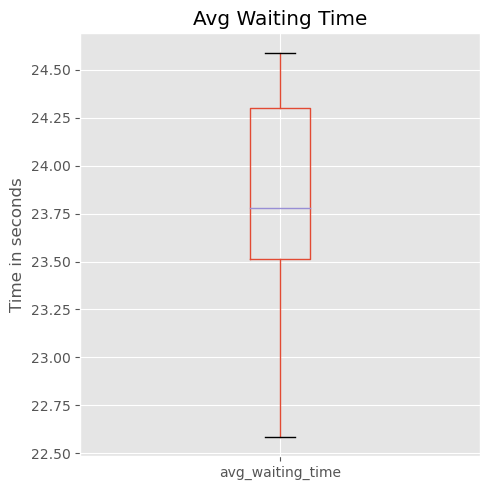

In [10]:
plt.style.use('ggplot')

# Plot the boxplot for 'avg_waiting_time'
plt.figure(figsize=(5, 5))
df[['avg_waiting_time']].boxplot()
plt.title("Avg Waiting Time")
plt.ylabel("Time in seconds")
plt.tight_layout()
plt.show()

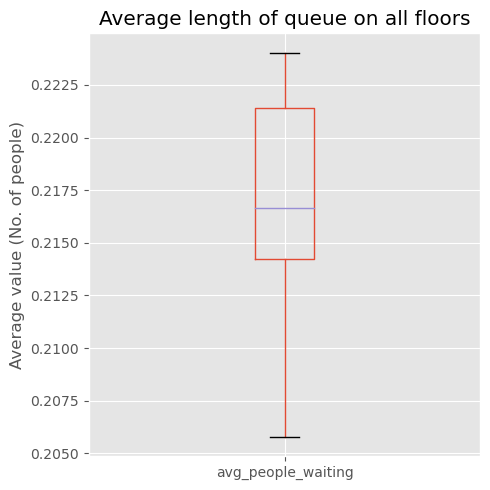

In [11]:
plt.style.use('ggplot')

# Plot the boxplot for 'avg_waiting_time'
plt.figure(figsize=(5, 5))
df[['avg_people_waiting']].boxplot()
plt.title("Average length of queue on all floors")
plt.ylabel("Average value (No. of people)")
plt.tight_layout()
plt.show()

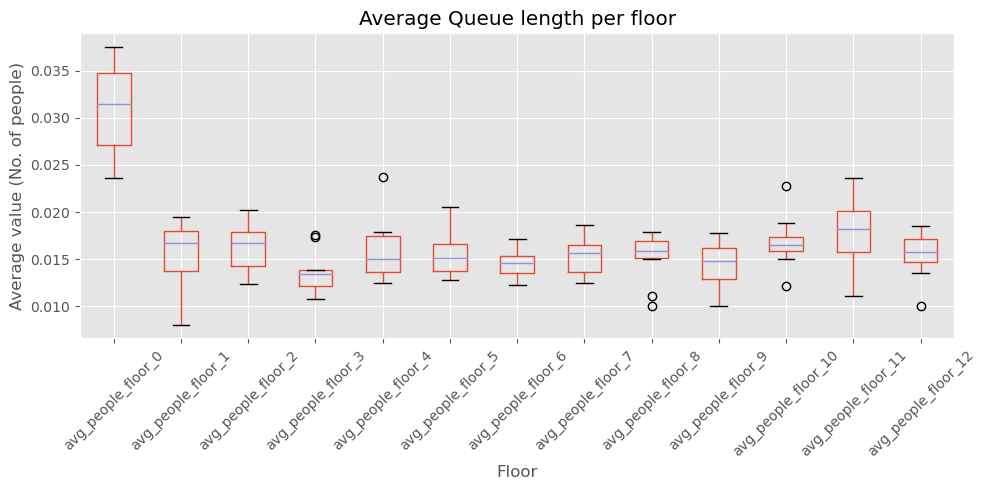

In [12]:
df_without_avg_waiting_time = df_except_time_moving.drop(columns=['avg_waiting_time', 'avg_people_waiting'])

# Plot the boxplot for other KPIs
ax = df_without_avg_waiting_time.boxplot()
ax.set_xlabel("Floor")
ax.set_ylabel("Average value (No. of people)")
ax.figure.set_size_inches(10, 5)
ax.set_title("Average Queue length per floor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

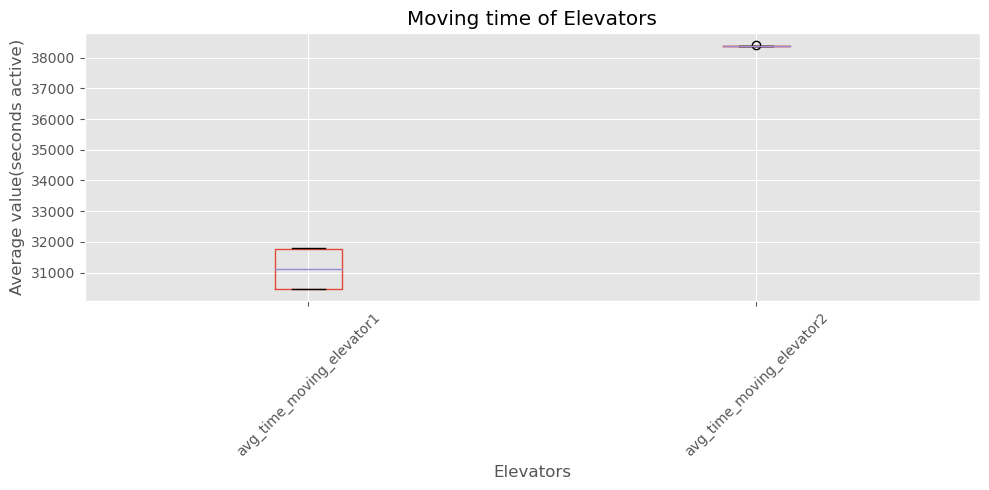

In [13]:
# Set the style
plt.style.use('ggplot')

ax = df_time_moving.boxplot()

ax.set_xlabel("Elevators")
ax.set_ylabel("Average value(seconds active)")
ax.figure.set_size_inches(10, 5)
ax.set_title("Moving time of Elevators")

# Display the plot
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()